In [1]:
import cProfile
import re
import scipy

import numpy as np
import random


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numba

In [2]:
cd C:\Users\ArianStolk\Documents\GitHub\SPDC


C:\Users\ArianStolk\Documents\GitHub\SPDC


In [3]:
%run main.py
%run physics.py

In [ ]:
rays_end = 5.0001
fibre_diam = 0.005
fibre_NA = 0.12

def get_results_evol(visualization,x):
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    Hit_Lens_True=((visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4
    
    dummy_new=[[[] for _ in range(5)] for _ in range(2)]
    for i,dummy_list in enumerate(visualization.dummy_surface):
        for j,attr in enumerate(dummy_list[0:-2]):

            dummy_new[i][j]=attr[Hit_Lens_True]

                
    visualization.dummy_surface=dummy_new  
   
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    coinc=len(visualization.coincidences[0][0])
    signal_e=(coinc)/(len(visualization.singles[1][0])+1)
    idler_e=(coinc)/(len(visualization.singles[0][0])+1)
    print("final coinc are",coinc)
    spectrum=np.histogram(np.concatenate((visualization.singles[0][2],visualization.singles[1][2])),np.linspace(600,1100,400))
    return [coinc,signal_e,idler_e,spectrum]

def focus_setup(y,sbeg,send,ibeg,iend,z_beg,z_end,offset=0):
    returnlist=[]
    pos=offset+y

    scale=((pos-z_beg)/(z_end-z_beg))
#     scale=((pos-z_beg)/(z_end-z_beg))[0]
    
    signal=sbeg+(send-sbeg)*scale
    idler=ibeg+(iend-ibeg)*scale

    spot_sig=np.histogram2d(signal[:,0],signal[:,1],[np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50)])[0]
    spot_idl=np.histogram2d(idler[:,0],idler[:,1],[np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50)])[0]
    
    comb_spot=(spot_sig+spot_idl)
    maxindex=np.unravel_index(np.argmax(comb_spot),(50,100))
    
    return [np.max(comb_spot),np.linspace(-0.4,-0.0,100)[maxindex[1]],np.linspace(-0.1,0.1,50)[maxindex[0]]]

In [ ]:
Optimize = True


pumps = [[x*0.001,x*0.001] for x in range(20,100,5)] 
# pumps =[[x*0.001,x*0.001] for x in range(25,250,25)]

pump_M2_list=[[1,1]]*len(pumps)
pump_focus_list=[[2.5,2.5]]*len(pumps)

xpos=np.linspace(3,6,20)

lensd_photons_1=[[[] for x in range(len(xpos))]for y in pumps]
lensd_fibre_1=[[[] for x in range(len(xpos))]for y in pumps]

for k in range(1):
    pumpcurv=True
    walkoff=True
    for i,pump in enumerate(pumps):
        pump=np.array(pump)
        print(pump)
        pump_focus=np.array(pump_focus_list[i])
        pump_M2 = pump_M2_list[i]
#     for i,pump in enumerate([[0.5,0.5]]):
        for j,holes in enumerate(xpos):
#         for j,holes in enumerate([4,5]):
            Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
            lenspos=25*holes
    #         print(lenspos)
            ACH=Lens.asphere_r(position = [0,0,lenspos],centre=[-0.18,0,0],f=250)
            Csetup=ExpSetup(Crystal1,ACH)
            sim2=Simulation(rays=[0],setup=Csetup)
            sim2.run(Ntot=90000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            print(len(sim2.complete_results[0][0]))
            vis2=Visualization(simulation=sim2)
#             plt.figure()
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[0]+(vis2.simulation.start_list[1][1]).T[0]),alpha=0.5)
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[1]+(vis2.simulation.start_list[1][1]).T[1]),alpha=0.5)
#             plt.show()
    #         vis2.showpos_single(pos=5.001)
    #         vis2.SPDC_list=SPDC_list
            Hit_Lens_True=((vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4

            send=np.float32(vis2.complete_results[0][0][...,-1][...,0:2])[Hit_Lens_True]
            sbeg=np.float32(vis2.complete_results[0][0][...,-2][...,0:2])[Hit_Lens_True]

            iend=np.float32(vis2.complete_results[1][0][...,-1][...,0:2])[Hit_Lens_True]
            ibeg=np.float32(vis2.complete_results[1][0][...,-2][...,0:2])[Hit_Lens_True]

            z_beg_val=np.float32(vis2.complete_results[0][0][...,-2][0][...,2])
            z_end_val=np.float32(vis2.complete_results[0][0][...,-1][0][...,2])


            [sbeg,send,ibeg,iend]=Visualization.select_NA_TRUE(sbeg,send,ibeg,iend,z_beg_val,z_end_val,core_diam=0.025,Num_Ap=0.22)
            
            
#             plt.plot(np.linspace(8,11,500),[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,offset=lenspos)[0] for x in np.linspace(8,11,500)])
#             plt.title("pump is {} and lensd is {}".format(pump,lenspos))
#             plt.show()

#             [(vis2.showpos_single(pos = x+lenspos),print(focus_setup(x+lenspos,sbeg,send,ibeg,iend,z_beg_val,z_end_val))) for x in np.linspace(15,21,25)]

    #         print(np.min([vis2.showpos_single(pos=x+lenspos) for x in np.linspace(0,100,100)]))
            
            scanlist=np.array([focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,lenspos) for x in np.linspace(8,11,500)]).T
            result_for_foc=[np.max(scanlist[0]),np.linspace(8,11,500)[np.argmax(scanlist[0])],scanlist[1][np.argmax(scanlist[0])],scanlist[2][np.argmax(scanlist[0])]]
            print(result_for_foc)
#             search_pos=[result_for_foc[2],result_for_foc[3],result_for_foc[1]+lenspos]
            search_pos=[-0.168,0,result_for_foc[1]+lenspos]
            if Optimize:
                dx=0.1
                dy=0.01
                dz=1
                res=np.empty((20,20,100))
                scale=1
                scale_evol=0.75
                coinc_start= 0
                coincs= 0
                been_0=False
                while dz>0.005 and dz<10:

                        print(dx,dy,dz,search_pos)

                        x_range=np.linspace(search_pos[0]-dx,search_pos[0]+dx,20,dtype=np.float32)
                        y_range=np.linspace(search_pos[1]-dy,search_pos[1]+dy,20,dtype=np.float32)
                        z_range=np.linspace(search_pos[2]-dz,search_pos[2]+dz,100,dtype=np.float32)

                        res=d_coinc(sbeg, send ,ibeg,iend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                        coincs=np.max(res)
                        maxindex=np.unravel_index(np.argmax(res),res.shape)


                        if coincs < 2:
                            dx *= 1.
                            dy *= 1.
                            dz *= 1.1
                            search_pos[2]+=0.01
                            been_0 =True
#                             if not coincs == 0: 
#                                 search_pos[2] = z_range[maxindex[2]]
                            dx = max(0.2,dx)
                            dy = max(0.05,dy)
                        elif maxindex[2]<30:
                            search_pos[2]=z_range[0]
                            dz *= 1.1
                        elif maxindex[2]>70:
                            search_pos[2] = z_range[-1]
                            dz *= 1.1

                        else:
                            if been_0:
                                dx=0.1
                                dy=0.02
                                dz=0.1
                                been_0 = False

                            scale *=scale_evol 
                            dx *= scale*(0.66+2*((abs(maxindex[0]-10))/20))
                            dy *= scale*(0.66+2*((abs(maxindex[1]-10))/20))
                            dz *= scale*(0.66+2*((abs(maxindex[2]-50))/100))

    #                         dx *= 2/100
    #                         dy *= 2/60
    #                         dz *= 2/100

                            search_pos = [x_range[maxindex[0]],y_range[maxindex[1]],z_range[maxindex[2]]]
                        diff=abs(coinc_start-coincs)
                        coinc_start=coincs
                        print("coincidences are",coincs,maxindex)

    #         vis2.showpos_single(pos=search_pos[-1])
            print(search_pos)
            lensd_fibre_1[i][j]=search_pos
#             del sim2.start_list
#             sim2.interpol_pos = 0
# #             print(hasattr(sim2,'start_list'))
#             sim2.run(Ntot=30000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
#             vis_result=Visualization(simulation=sim2)

    #         vis_result.showpos_single(pos=search_pos[-1])


            lensd_photons_1[i][j]+=get_results_evol(vis2,search_pos)
    print("doing iteration {}".format(k+1))



            
        



[ 0.02  0.02]


C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:587: RuntimeWarning: invalid value encountered in arcsin
  angles =  np.arcsin(np.sin(angle)*indexfract)+np.arctan(position_on_lens*(alpha/np.cos(alpha)))


323707


C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:396: RuntimeWarning: invalid value encountered in less
  iNA_TRUE=(iNA*iNA).sum(axis=1) < Num_Ap*Num_Ap


[35917.0, 9.5991983967935877, -0.31515151515151518, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 84.599198396793582]
coincidences are 147085.0 (8, 9, 55)
0.0645 0.0057 0.57 [-0.18378948, -0.00052631577, 84.710312]
coincidences are 147365.0 (10, 11, 49)
0.023945625 0.00243675 0.218025 [-0.18039474, 0.00037368425, 84.704552]
coincidences are 147578.0 (9, 10, 51)
0.00767756601563 0.000678482578125 0.062545921875 [-0.18165503, 0.00050193426, 84.711159]
coincidences are 147555.0 (10, 4, 49)
0.00160329171561 0.000270491921576 0.0134571460034 [-0.18125094, 0.00010912856, 84.710526]
coincidences are 147585.0 (7, 19, 52)
[-0.18167286, 0.00037962047, 84.711205]


C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:386: RuntimeWarning: invalid value encountered in less
  core_dist_check=((pos-fibre_pos)*(pos-fibre_pos)).sum(axis=1)<(core_diam/2)**2
C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:387: RuntimeWarning: invalid value encountered in less
  inc_angle_check=(angle*angle).sum(axis=1)<Num_Ap**2


final coinc are 1068
323380
[38857.0, 9.545090180360722, -0.31515151515151518, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 88.492458601413347]
coincidences are 139535.0 (8, 10, 55)
0.0645 0.00495 0.57 [-0.18378948, 0.00052631577, 88.603569]
coincidences are 139930.0 (10, 9, 49)
0.023945625 0.002116125 0.218025 [-0.18039474, 0.00026578945, 88.597809]
coincidences are 139955.0 (9, 8, 50)
0.00767756601563 0.000767756601563 0.0607063359375 [-0.18165503, -6.8335547e-05, 88.600014]
coincidences are 139968.0 (10, 10, 49)
0.00160329171561 0.000160329171561 0.0130613475916 [-0.18125094, -2.7927304e-05, 88.599403]
coincidences are 139971.0 (9, 9, 49)
[-0.18133533, -3.6365684e-05, 88.599274]
final coinc are 1332
324256
[41830.0, 9.4909819639278563, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 92.385718806033111]
coincidences are 133503.0 (8, 10, 55)
0.0645 0.00495 0.57 [-0.18378948, 0.00052631577, 92.496826]
coincidences are 133782.0 (10, 9, 49)
0.023945625 0.002116125 0.2

C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:395: RuntimeWarning: invalid value encountered in less
  sNA_TRUE=(sNA*sNA).sum(axis=1) < Num_Ap*Num_Ap


[57958.0, 9.3286573146292575, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 108.01286784094503]
coincidences are 110302.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 108.10378]
coincidences are 110323.0 (10, 11, 50)
0.023945625 0.00243675 0.20604375 [-0.18039474, 0.00037368425, 108.10938]
coincidences are 110328.0 (9, 10, 50)
0.00767756601563 0.000678482578125 0.0573703066406 [-0.18165503, 0.00050193426, 108.11147]
coincidences are 110330.0 (10, 6, 50)
0.00160329171561 0.000227556695929 0.0119805335664 [-0.18125094, 0.00025196699, 108.11205]
coincidences are 110330.0 (9, 8, 50)
[-0.18133533, 0.00021603699, 108.11217]
final coinc are 1735
322920
[62428.0, 9.292585170340681, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 111.9241641177091]
coincidences are 104948.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 112.01508]
coincidences are 104956.0 (10, 8, 51)
0.023945625 0.0023945625 0.2122875 [-0.18039474, -0.00025

coincidences are 67891.0 (8, 6, 53)
0.0645 0.00795 0.54 [-0.18378948, -0.0036842106, 155.19348]
coincidences are 67892.0 (10, 11, 49)
0.023945625 0.003398625 0.20655 [-0.18039474, -0.0024289475, 155.18803]
coincidences are 67893.0 (9, 10, 49)
0.00767756601563 0.000946304648438 0.05925403125 [-0.18165503, -0.0022500725, 155.18594]
coincidences are 67893.0 (7, 9, 51)
0.00233206067725 0.000227556695929 0.0127488751611 [-0.18367545, -0.002299878, 155.18774]
coincidences are 67893.0 (7, 19, 44)
[-0.18428916, -0.0020723213, 155.18633]
final coinc are 235
323459
[70415.0, 9.0521042084168339, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 159.05210420841684]
coincidences are 65814.0 (8, 11, 53)
0.0645 0.0057 0.54 [-0.18378948, 0.0015789474, 159.12282]
coincidences are 65814.0 (10, 9, 49)
0.023945625 0.00243675 0.20655 [-0.18039474, 0.0012789475, 159.11737]
coincidences are 65815.0 (9, 3, 47)
0.00767756601563 0.0013980853125 0.0627395625 [-0.18165503, -0.00038830255, 159.106

coincidences are 114057.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 123.77902]
coincidences are 114062.0 (10, 11, 49)
0.023945625 0.00243675 0.2122875 [-0.18039474, 0.00037368425, 123.77341]
coincidences are 114063.0 (9, 5, 49)
0.00767756601563 0.00119248453125 0.0608999765625 [-0.18165503, -0.00078056578, 123.77127]
coincidences are 114064.0 (12, 5, 58)
0.00208913769003 0.00043767908811 0.0158006892316 [-0.17963462, -0.0013454269, 123.78173]
coincidences are 114064.0 (10, 11, 49)
[-0.17952466, -0.0012763196, 123.78157]
final coinc are 2757
338585
[99363.0, 9.1903807615230466, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 127.61143339310198]
coincidences are 109957.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 127.70234]
coincidences are 109964.0 (10, 8, 49)
0.023945625 0.0023945625 0.2122875 [-0.18039474, -0.00025526318, 127.69673]
coincidences are 109964.0 (9, 13, 48)
0.00767756601563 0.0009697978125 0.0626911523438 [-0.181655

final coinc are 1115
342419
[41845.0, 9.4969939879759515, -0.32323232323232326, 0.010204081632653073]
0.1 0.01 1 [-0.168, 0, 92.391730830081215]
coincidences are 166305.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 92.482643]
coincidences are 166578.0 (10, 11, 50)
0.023945625 0.00243675 0.20604375 [-0.18039474, 0.00037368425, 92.488251]
coincidences are 166625.0 (9, 8, 52)
0.00767756601563 0.000884083359375 0.0608472949219 [-0.18165503, -1.1065752e-05, 92.498657]
coincidences are 166631.0 (10, 10, 47)
0.00160329171561 0.000184621470282 0.0138617743744 [-0.18125094, 3.5464953e-05, 92.495583]
coincidences are 166635.0 (9, 1, 52)
[-0.18133533, -0.00012972268, 92.496284]
final coinc are 1225
341138
[46209.0, 9.454909819639278, -0.32323232323232326, 0.010204081632653073]
0.1 0.01 1 [-0.168, 0, 96.297015082797188]
coincidences are 159746.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 96.387924]
coincidences are 159842.0 (10, 8, 50)
0.023945625 0.0023945625 0

coincidences are 111451.0 (9, 14, 46)
[-0.17956974, 0.0010150014, 135.5397]
final coinc are 4930
340708
[120883.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 139.39341841577894]
coincidences are 108762.0 (8, 11, 53)
0.0645 0.0057 0.54 [-0.18378948, 0.0015789474, 139.46413]
coincidences are 108763.0 (10, 6, 49)
0.023945625 0.003398625 0.20655 [-0.18039474, -0.00052105257, 139.45868]
coincidences are 108764.0 (9, 8, 49)
0.00767756601563 0.00123306363281 0.05925403125 [-0.18165503, -0.0010576776, 139.45659]
coincidences are 108764.0 (9, 5, 51)
0.00184621470282 0.000452572886481 0.0127488751611 [-0.18205912, -0.0016417603, 139.45839]
coincidences are 108764.0 (2, 5, 58)
[-0.18351667, -0.001856137, 139.46057]
final coinc are 1253
341357
[119588.0, 9.1122244488977948, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 143.32275076468727]
coincidences are 105078.0 (8, 7, 53)
0.0645 0.0072 0.54 [-0.18378948, -0.0026315791, 143.39346]
c

coincidences are 148268.0 (11, 8, 47)
[-0.18015127, -0.00028412466, 104.20015]
final coinc are 1905
338020
[60155.0, 9.3286573146292575, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 108.01286784094503]
coincidences are 142601.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 108.10378]
coincidences are 142613.0 (10, 9, 50)
0.023945625 0.00243675 0.20604375 [-0.18039474, -0.00082631578, 108.10938]
coincidences are 142614.0 (10, 14, 50)
0.00666735996094 0.00108968414063 0.0573703066406 [-0.17913444, 0.00032793422, 108.11147]
coincidences are 142614.0 (8, 1, 51)
0.00181425115187 0.000537861281287 0.0123435800381 [-0.18018718, -0.00064704631, 108.1132]
coincidences are 142614.0 (4, 2, 62)
[-0.18123753, -0.0010716736, 108.11633]
final coinc are 1431
338840
[67207.0, 9.292585170340681, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 111.9241641177091]
coincidences are 138156.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 

[118782.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 151.18742748655205]
coincidences are 101498.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 151.25813]
coincidences are 101501.0 (10, 5, 50)
0.023945625 0.00371925 0.200475 [-0.18039474, -0.0032263158, 151.26358]
coincidences are 101501.0 (9, 11, 50)
0.00767756601563 0.00119248453125 0.0558197578125 [-0.18165503, -0.0026390657, 151.26561]
coincidences are 101502.0 (14, 11, 44)
0.00257498366446 0.000286755264624 0.0137761417914 [-0.17801829, -0.0024507786, 151.25941]
coincidences are 101502.0 (8, 2, 52)
[-0.17842487, -0.0026771643, 151.26012]
final coinc are 522
338517
[113476.0, 9.0641282565130261, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 155.11675983546039]
coincidences are 98656.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 155.18747]
coincidences are 98656.0 (10, 9, 51)
0.023945625 0.00243675 0.20655 [-0.18039474, -0.00082631578, 1

final coinc are 2493
334116
[81969.0, 9.2384769539078153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 119.76479274338149]
coincidences are 126247.0 (8, 8, 54)
0.0645 0.00645 0.555 [-0.18378948, -0.0015789474, 119.85571]
coincidences are 126257.0 (10, 12, 48)
0.023945625 0.0031201875 0.21853125 [-0.18039474, 0.00011842101, 119.83889]
coincidences are 126257.0 (10, 6, 53)
0.00666735996094 0.00139530884766 0.0663788671875 [-0.17913444, -0.0010311217, 119.85434]
coincidences are 126258.0 (7, 6, 42)
0.00202521058813 0.000467973506483 0.0172222045258 [-0.18088901, -0.0015451829, 119.84428]
coincidences are 126258.0 (9, 10, 49)
[-0.1809956, -0.0015205527, 119.84411]
final coinc are 1998
334870
[90847.0, 9.214428857715431, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 123.68811306824176]
coincidences are 122649.0 (8, 7, 54)
0.0645 0.0072 0.555 [-0.18378948, -0.0026315791, 123.77902]
coincidences are 122653.0 (10, 13, 48)
0.023945625 0.003888 0.218531

final coinc are 917
333239
[30684.0, 9.5511022044088172, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 88.498470625461451]
coincidences are 166939.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 88.589378]
coincidences are 167211.0 (10, 11, 49)
0.023945625 0.00243675 0.2122875 [-0.18039474, 0.00037368425, 88.583771]
coincidences are 167363.0 (9, 7, 51)
0.00767756601563 0.00098688375 0.0608999765625 [-0.18165503, -0.00026756575, 88.590202]
coincidences are 167355.0 (10, 9, 50)
0.00160329171561 0.000237314701758 0.0127176279181 [-0.18125094, -0.000319507, 88.59082]
coincidences are 167368.0 (8, 19, 51)
[-0.1815041, -8.2192302e-05, 88.591209]
final coinc are 1046
333167
[34972.0, 9.4969939879759515, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 92.391730830081215]
coincidences are 161225.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 92.482643]
coincidences are 161399.0 (10, 8, 50)
0.023945625 0.0023945625 0.2060437

final coinc are 2859
333491
[114629.0, 9.1482965931863731, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 135.46408606687058]
coincidences are 110859.0 (8, 11, 53)
0.0645 0.0057 0.54 [-0.18378948, 0.0015789474, 135.53479]
coincidences are 110861.0 (10, 6, 49)
0.023945625 0.003398625 0.20655 [-0.18039474, -0.00052105257, 135.52934]
coincidences are 110861.0 (9, 8, 50)
0.00767756601563 0.00123306363281 0.057511265625 [-0.18165503, -0.0010576776, 135.53143]
coincidences are 110861.0 (9, 11, 49)
0.00184621470282 0.000296513270453 0.0123739082446 [-0.18205912, -0.00086298329, 135.53085]
coincidences are 110861.0 (8, 15, 44)
[-0.18235064, -0.00069131772, 135.52948]
final coinc are 3771
332220
[117451.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 139.39341841577894]
coincidences are 107090.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 139.46413]
coincidences are 107089.0 (10, 11, 50)
0.023945625 0.00243675 0.200475

final coinc are 1211
331502
[49189.0, 9.3647294589178358, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 104.101571564181]
coincidences are 142927.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 104.19248]
coincidences are 142941.0 (10, 8, 50)
0.023945625 0.0023945625 0.20604375 [-0.18039474, -0.00025526318, 104.19809]
coincidences are 142941.0 (9, 8, 49)
0.00767756601563 0.000868777207031 0.0591088007813 [-0.18165503, -0.00063335197, 104.19601]
coincidences are 142944.0 (13, 12, 46)
0.00233206067725 0.00023640242282 0.0138397715579 [-0.17882645, -0.00040472639, 104.19183]
coincidences are 142944.0 (7, 11, 49)
[-0.17944016, -0.00036739968, 104.19169]
final coinc are 1587
332631
[56590.0, 9.3286573146292575, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 108.01286784094503]
coincidences are 138177.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 108.10378]
coincidences are 138182.0 (10, 6, 50)
0.023945625 0.003398625 

final coinc are 6419
330779
[113970.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 151.18742748655205]
coincidences are 97436.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 151.25813]
coincidences are 97440.0 (10, 10, 51)
0.023945625 0.002116125 0.20655 [-0.18039474, -0.00022631577, 151.27449]
coincidences are 97440.0 (9, 15, 48)
0.00767756601563 0.00103557867188 0.060996796875 [-0.18165503, 0.00099880924, 151.26823]
coincidences are 97440.0 (10, 0, 54)
0.00160329171561 0.000543921516486 0.0142818281433 [-0.18125094, -3.6769437e-05, 151.27377]
coincidences are 97440.0 (7, 17, 41)
[-0.18167286, 0.00039264228, 151.27132]
final coinc are 3937
332251
[109153.0, 9.0701402805611231, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 155.1227718595085]
coincidences are 95483.0 (8, 12, 53)
0.0645 0.00645 0.54 [-0.18378948, 0.0026315791, 155.19348]
coincidences are 95485.0 (10, 7, 50)
0.023945625 0.003483 0.200475 [-0.180

coincidences are 127860.0 (9, 18, 51)
[-0.1809956, -0.0013213708, 115.92634]
final coinc are 1974
331441
[79776.0, 9.2384769539078153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 119.76479274338149]
coincidences are 123895.0 (8, 8, 54)
0.0645 0.00645 0.555 [-0.18378948, -0.0015789474, 119.85571]
coincidences are 123900.0 (10, 8, 49)
0.023945625 0.0031201875 0.2122875 [-0.18039474, -0.0025973686, 119.8501]
coincidences are 123901.0 (9, 15, 50)
0.00767756601563 0.00152694175781 0.0591088007812 [-0.18165503, -0.00079094421, 119.85224]
coincidences are 123901.0 (9, 2, 42)
0.00184621470282 0.000705375516714 0.0153359630777 [-0.18205912, -0.0019964245, 119.84328]
coincidences are 123901.0 (9, 10, 51)
[-0.18215629, -0.0019592994, 119.84375]
final coinc are 1446
331701
[88732.0, 9.208416833667334, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 123.68210104419366]
coincidences are 119836.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 12

coincidences are 171708.0 (7, 17, 50)
[-0.18167286, 4.3256132e-05, 84.69429]
final coinc are 777
330474
[25831.0, 9.5511022044088172, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 88.498470625461451]
coincidences are 164421.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 88.589378]
coincidences are 164946.0 (10, 11, 49)
0.023945625 0.00243675 0.2122875 [-0.18039474, 0.00037368425, 88.583771]
coincidences are 165009.0 (9, 8, 50)
0.00767756601563 0.000884083359375 0.0591088007812 [-0.18165503, -1.1065752e-05, 88.585915]
coincidences are 165008.0 (10, 15, 48)
0.00160329171561 0.000324486220496 0.013091675798 [-0.18125094, 0.00050077197, 88.584122]
coincidences are 165013.0 (8, 4, 58)
[-0.1815041, 0.00031291152, 88.586372]
final coinc are 807
331862
[30207.0, 9.4969939879759515, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 92.391730830081215]
coincidences are 159163.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 92.

coincidences are 112281.0 (4, 10, 60)
[-0.18123753, 0.00015200277, 131.60861]
final coinc are 4612
331988
[112607.0, 9.1482965931863731, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 135.46408606687058]
coincidences are 109654.0 (8, 10, 53)
0.0645 0.00495 0.54 [-0.18378948, 0.00052631577, 135.53479]
coincidences are 109657.0 (10, 9, 49)
0.023945625 0.002116125 0.20655 [-0.18039474, 0.00026578945, 135.52934]
coincidences are 109659.0 (10, 17, 51)
0.00666735996094 0.00121412671875 0.05925403125 [-0.17913444, 0.0019364144, 135.5356]
coincidences are 109660.0 (10, 8, 50)
0.00139233227934 0.00033037526261 0.0123739082446 [-0.17878354, 0.0017447101, 135.53619]
coincidences are 109660.0 (7, 13, 51)
[-0.17914994, 0.0018664274, 135.53658]
final coinc are 2302
331649
[116021.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 139.39341841577894]
coincidences are 106265.0 (8, 7, 53)
0.0645 0.0072 0.54 [-0.18378948, -0.0026315791, 139.46413

coincidences are 148204.0 (9, 4, 49)
[-0.18053995, 4.5678913e-05, 100.28357]
final coinc are 1216
330882
[44957.0, 9.3647294589178358, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 104.101571564181]
coincidences are 142076.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 104.19248]
coincidences are 142094.0 (10, 9, 49)
0.023945625 0.00243675 0.2122875 [-0.18039474, -0.00082631578, 104.18687]
coincidences are 142094.0 (9, 10, 51)
0.00767756601563 0.000678482578125 0.0608999765625 [-0.18165503, -0.00069806579, 104.19331]
coincidences are 142094.0 (9, 5, 50)
0.00184621470282 0.000249024308752 0.0127176279181 [-0.18205912, -0.0010194522, 104.19392]
coincidences are 142095.0 (10, 15, 51)
[-0.18196195, -0.00087528024, 104.19431]
final coinc are 1136
331951
[51750.0, 9.3286573146292575, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 108.01286784094503]
coincidences are 137280.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577,

coincidences are 99965.0 (7, 8, 49)
[-0.18254498, -0.00046673315, 147.31323]
final coinc are 3395
329890
[113360.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 151.18742748655205]
coincidences are 97097.0 (8, 11, 53)
0.0645 0.0057 0.54 [-0.18378948, 0.0015789474, 151.25813]
coincidences are 97099.0 (10, 9, 50)
0.023945625 0.00243675 0.200475 [-0.18039474, 0.0012789475, 151.26358]
coincidences are 97099.0 (9, 9, 50)
0.00767756601563 0.00078128296875 0.0558197578125 [-0.18165503, 0.0011506975, 151.26561]
coincidences are 97099.0 (9, 18, 51)
0.00184621470282 0.000360916108923 0.0120099697668 [-0.18205912, 0.0018497402, 151.2673]
coincidences are 97099.0 (9, 16, 51)
[-0.18215629, 0.0020966828, 151.26767]
final coinc are 996
331150
[108279.0, 9.0641282565130261, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 155.11675983546039]
coincidences are 95157.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 155.18747]
coinci

coincidences are 127166.0 (9, 10, 48)
[-0.18215629, -0.0011991668, 115.93032]
final coinc are 1680
330594
[75515.0, 9.2384769539078153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 119.76479274338149]
coincidences are 123126.0 (8, 7, 54)
0.0645 0.0072 0.555 [-0.18378948, -0.0026315791, 119.85571]
coincidences are 123132.0 (10, 8, 49)
0.023945625 0.003483 0.2122875 [-0.18039474, -0.0037684212, 119.8501]
coincidences are 123134.0 (10, 17, 49)
0.00666735996094 0.00199837125 0.0608999765625 [-0.17913444, -0.0010186844, 119.84795]
coincidences are 123134.0 (9, 9, 48)
0.00160329171561 0.000480545836523 0.0134883932465 [-0.17948535, -0.0011238618, 119.84611]
coincidences are 123134.0 (9, 7, 47)
[-0.17956974, -0.0012503212, 119.84543]
final coinc are 2077
332189
[86595.0, 9.208416833667334, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 123.68210104419366]
coincidences are 120538.0 (8, 8, 54)
0.0645 0.00645 0.555 [-0.18378948, -0.0015789474, 123.77301]

coincidences are 93102.0 (3, 0, 26)
0.00208913769003 0.000263891076636 0.0301737951984 [-0.18280387, 0.00060271722, 159.11522]
coincidences are 93102.0 (3, 0, 73)
0.00208913769003 0.000263891076636 0.0331911747182 [-0.18280387, 0.00060271722, 159.14539]
coincidences are 93102.0 (3, 0, 26)
0.00208913769003 0.000263891076636 0.03651029219 [-0.18280387, 0.00060271722, 159.1122]
coincidences are 93102.0 (3, 0, 73)
0.00208913769003 0.000263891076636 0.040161321409 [-0.18280387, 0.00060271722, 159.14871]
coincidences are 93102.0 (3, 0, 26)
0.00208913769003 0.000263891076636 0.0441774535499 [-0.18280387, 0.00060271722, 159.10855]
coincidences are 93102.0 (3, 0, 73)
0.00208913769003 0.000263891076636 0.0485951989049 [-0.18280387, 0.00060271722, 159.15273]
coincidences are 93102.0 (3, 0, 26)
0.00208913769003 0.000263891076636 0.0534547187954 [-0.18280387, 0.00060271722, 159.10413]
coincidences are 93102.0 (3, 0, 73)
0.00208913769003 0.000263891076636 0.0588001906749 [-0.18280387, 0.00060271722,

coincidences are 169699.0 (10, 8, 48)
0.00160329171561 0.000184621470282 0.0127378467224 [-0.18125094, 6.8040373e-07, 84.689636]
coincidences are 169701.0 (10, 15, 44)
[-0.18116656, 0.00010756652, 84.688217]
final coinc are 676
331452
[22192.0, 9.5571142284569142, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 88.504482649509541]
coincidences are 164431.0 (8, 9, 53)
0.0645 0.0057 0.54 [-0.18378948, -0.00052631577, 88.575188]
coincidences are 165050.0 (10, 10, 50)
0.023945625 0.002116125 0.200475 [-0.18039474, -0.00022631577, 88.580643]
coincidences are 165109.0 (9, 10, 49)
0.00767756601563 0.000589208554688 0.057511265625 [-0.18165503, -0.00011494077, 88.578621]
coincidences are 165132.0 (10, 12, 50)
0.00160329171561 0.000160329171561 0.0120099697668 [-0.18125094, 4.0114115e-05, 88.579201]
coincidences are 165134.0 (10, 17, 54)
[-0.18116656, 0.00016668977, 88.580292]
final coinc are 664
331293
[26022.0, 9.4969939879759515, -0.1171717171717172, 0.0061224489795918408]

coincidences are 112225.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 131.62566]
coincidences are 112227.0 (10, 7, 48)
0.023945625 0.002673 0.21853125 [-0.18039474, -0.00077631581, 131.60884]
coincidences are 112228.0 (8, 18, 51)
0.00868777207031 0.0016464009375 0.0626911523438 [-0.18417563, 0.0016153158, 131.61546]
coincidences are 112228.0 (10, 4, 48)
0.00181425115187 0.000656373748755 0.0138851106949 [-0.18371837, 0.0006621363, 131.61356]
coincidences are 112228.0 (6, 16, 50)
[-0.18438677, 0.0011112341, 131.61369]
final coinc are 1253
330411
[110321.0, 9.1482965931863731, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 135.46408606687058]
coincidences are 108920.0 (8, 10, 53)
0.0645 0.00495 0.54 [-0.18378948, 0.00052631577, 135.53479]
coincidences are 108924.0 (10, 9, 49)
0.023945625 0.002116125 0.20655 [-0.18039474, 0.00026578945, 135.52934]
coincidences are 108924.0 (9, 11, 49)
0.00767756601563 0.000678482578125 0.05925403125 [-0.18165503, 0.00

coincidences are 147474.0 (8, 10, 54)
0.0645 0.00495 0.555 [-0.18378948, 0.00052631577, 100.28118]
coincidences are 147566.0 (10, 9, 49)
0.023945625 0.002116125 0.2122875 [-0.18039474, 0.00026578945, 100.27557]
coincidences are 147575.0 (9, 8, 51)
0.00767756601563 0.000767756601563 0.0608999765625 [-0.18165503, -6.8335547e-05, 100.28201]
coincidences are 147578.0 (10, 18, 49)
0.00160329171561 0.000354667561331 0.0131030105823 [-0.18125094, 0.00061860459, 100.28139]
coincidences are 147580.0 (9, 9, 53)
[-0.18133533, 0.00059993786, 100.28231]
final coinc are 919
332160
[39927.0, 9.3647294589178358, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 104.101571564181]
coincidences are 142153.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 104.19248]
coincidences are 142185.0 (10, 10, 49)
0.023945625 0.002116125 0.2122875 [-0.18039474, -0.00022631577, 104.18687]
coincidences are 142187.0 (9, 12, 51)
0.00767756601563 0.000767756601563 0.0608999765625 [-0.181655

coincidences are 99853.0 (8, 7, 53)
0.0645 0.0072 0.54 [-0.18378948, -0.0026315791, 147.3288]
coincidences are 99854.0 (10, 11, 49)
0.023945625 0.003078 0.20655 [-0.18039474, -0.001494737, 147.32335]
coincidences are 99855.0 (9, 10, 49)
0.00767756601563 0.000857030625 0.05925403125 [-0.18165503, -0.001332737, 147.32126]
coincidences are 99855.0 (8, 18, 47)
0.00208913769003 0.000395907975439 0.0134988089941 [-0.18286729, -0.00056592014, 147.31827]
coincidences are 99855.0 (9, 14, 49)
[-0.18297724, -0.00037838478, 147.31813]
final coinc are 2294
330795
[114080.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 151.18742748655205]
coincidences are 97383.0 (8, 12, 54)
0.0645 0.00645 0.555 [-0.18378948, 0.0026315791, 151.27834]
coincidences are 97384.0 (10, 12, 48)
0.023945625 0.0031201875 0.21853125 [-0.18039474, 0.0043289475, 151.26152]
coincidences are 97383.0 (8, 0, 51)
0.00868777207031 0.00218510630859 0.0626911523438 [-0.18417563, 0.00120876, 151

coincidences are 97384.0 (12, 1, 26)
0.00208913769003 0.00107855481701 3.17637961652 [-0.18280387, -0.00074633514, 149.75211]
coincidences are 97383.0 (0, 5, 73)
0.00208913769003 0.00107855481701 3.49401757818 [-0.18280387, -0.00074633514, 152.92848]
coincidences are 97384.0 (11, 8, 26)
0.00208913769003 0.00107855481701 3.84341933599 [-0.18280387, -0.00074633514, 149.43446]
coincidences are 97383.0 (0, 7, 73)
0.00208913769003 0.00107855481701 4.22776126959 [-0.18280387, -0.00074633514, 153.27788]
coincidences are 97384.0 (10, 10, 26)
0.00208913769003 0.00107855481701 4.65053739655 [-0.18280387, -0.00074633514, 149.05011]
coincidences are 97383.0 (2, 8, 73)
0.00208913769003 0.00107855481701 5.11559113621 [-0.18280387, -0.00074633514, 153.70065]
coincidences are 97384.0 (9, 5, 26)
0.00208913769003 0.00107855481701 5.62715024983 [-0.18280387, -0.00074633514, 148.58507]
coincidences are 97383.0 (13, 9, 73)
0.00208913769003 0.00107855481701 6.18986527481 [-0.18280387, -0.00074633514, 154.21

coincidences are 132138.0 (9, 9, 48)
0.00767756601563 0.00078128296875 0.0626911523438 [-0.18165503, -0.00095456577, 112.00905]
coincidences are 132138.0 (9, 1, 53)
0.00184621470282 0.000385636390356 0.0142818281433 [-0.18205912, -0.0016536084, 112.01348]
coincidences are 132139.0 (11, 14, 43)
[-0.18176761, -0.0014709386, 112.0116]
final coinc are 1306
331330
[61506.0, 9.2625250501001997, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 115.84147241852126]
coincidences are 127417.0 (8, 8, 54)
0.0645 0.00645 0.555 [-0.18378948, -0.0015789474, 115.93238]
coincidences are 127422.0 (10, 12, 48)
0.023945625 0.0031201875 0.21853125 [-0.18039474, 0.00011842101, 115.91557]
coincidences are 127423.0 (9, 7, 51)
0.00767756601563 0.0012636759375 0.0626911523438 [-0.18165503, -0.00070268096, 115.92219]
coincidences are 127423.0 (10, 8, 49)
0.00160329171561 0.000343858069556 0.0134883932465 [-0.18125094, -0.00090220873, 115.92155]
coincidences are 127423.0 (6, 12, 51)
[-0.18184163,

coincidences are 92146.0 (8, 5, 51)
0.00868777207031 0.00152694175781 0.05925403125 [-0.18417563, -0.0013595625, 159.12363]
coincidences are 92146.0 (10, 7, 48)
0.00181425115187 0.000463808558936 0.0131238420776 [-0.18371837, -0.0017613893, 159.12183]
coincidences are 92146.0 (6, 16, 57)
[-0.18438677, -0.0014440466, 159.12381]
final coinc are 0
[ 0.09  0.09]
332057
[16461.0, 9.623246492985972, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 84.62324649298597]
coincidences are 167901.0 (8, 9, 52)
0.0645 0.0057 0.525 [-0.18378948, -0.00052631577, 84.673752]
coincidences are 168954.0 (10, 11, 50)
0.023945625 0.00243675 0.19490625 [-0.18039474, 0.00037368425, 84.679054]
coincidences are 169065.0 (9, 8, 51)
0.00767756601563 0.000884083359375 0.0559137304688 [-0.18165503, -1.1065752e-05, 84.684959]
coincidences are 169100.0 (10, 12, 47)
0.00160329171561 0.000240567370367 0.0127378467224 [-0.18125094, 0.00022158776, 84.682137]
coincidences are 169106.0 (8, 11, 55)
[-0.18150

coincidences are 115827.0 (9, 1, 49)
0.00767756601563 0.00157592144531 0.0608999765625 [-0.18165503, -0.0023977666, 127.68858]
coincidences are 115827.0 (9, 15, 51)
0.00184621470282 0.000578412417975 0.0131030105823 [-0.18205912, -0.0014853909, 127.69042]
coincidences are 115827.0 (8, 16, 52)
[-0.18235064, -0.0010896351, 127.69109]
final coinc are 2177
331621
[101054.0, 9.1663326653306605, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 1 [-0.168, 0, 131.53475371796225]
coincidences are 112225.0 (8, 9, 54)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 131.62566]
coincidences are 112229.0 (10, 7, 48)
0.023945625 0.003078 0.21853125 [-0.18039474, -0.0020263158, 131.60884]
coincidences are 112230.0 (11, 15, 50)
0.00767756601563 0.00150629625 0.0608472949219 [-0.17661385, -0.00024431577, 131.61105]
coincidences are 112231.0 (8, 6, 45)
0.00208913769003 0.000505197640723 0.0146318729507 [-0.17782611, -0.00079926703, 131.60551]
coincidences are 112231.0 (8, 7, 44)
[-0.17815597, -0.00

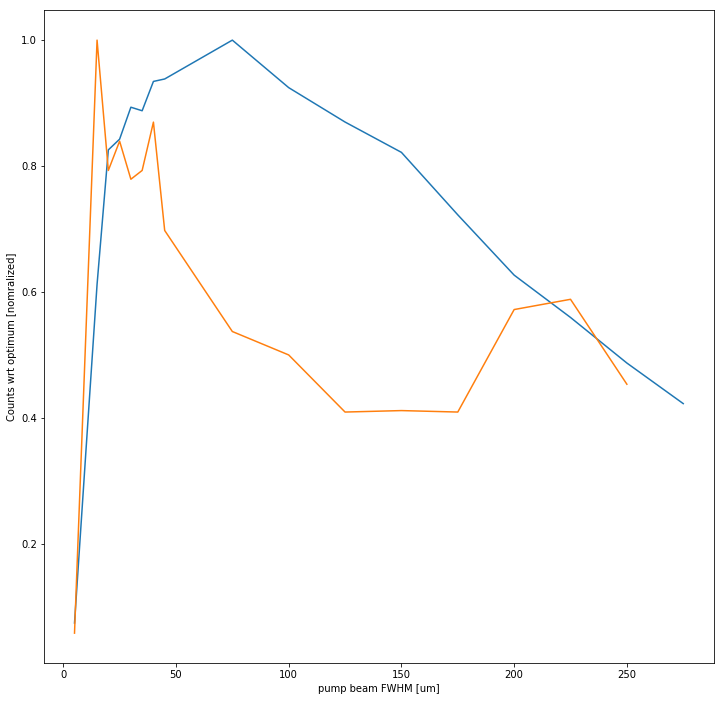

In [125]:
data_smf =np.load("C:/Users/ArianStolk/Documents/25042019_SMF_5mmBBO.npz")['arr_0'][1:-1]
data_smf = data_smf/max(data_smf)

plotlist = []
plt.figure(figsize=[12,12])
for y,pump in enumerate(pumps):
#     c = ['rx','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    plotlist.append(max([(lensd_photons_1[y][0][0]) for kk in range(1)]))
plotlist = np.array(plotlist)/max(plotlist)
plt.plot([p[0]*1000 for p in pumps],plotlist)
plt.plot([p[0]*1000 for p in pumps][0:-1],data_smf)
plt.xlabel("pump beam FWHM [um]")
plt.ylabel("Counts wrt optimum [nomralized]")
plt.legend()
plt.show()


# for x,x_pos in enumerate(xpos):
#     plt.figure()
#     [plt.plot(lensd_photons_1[y][x][3][1][0:-1],lensd_photons_1[y][x][3][0]/max(lensd_photons_1[y][x][3][0])) for y,j in enumerate(pumps)] 
#     plt.title("Lensd is = {}".format(x_pos*25))
#     plt.show()

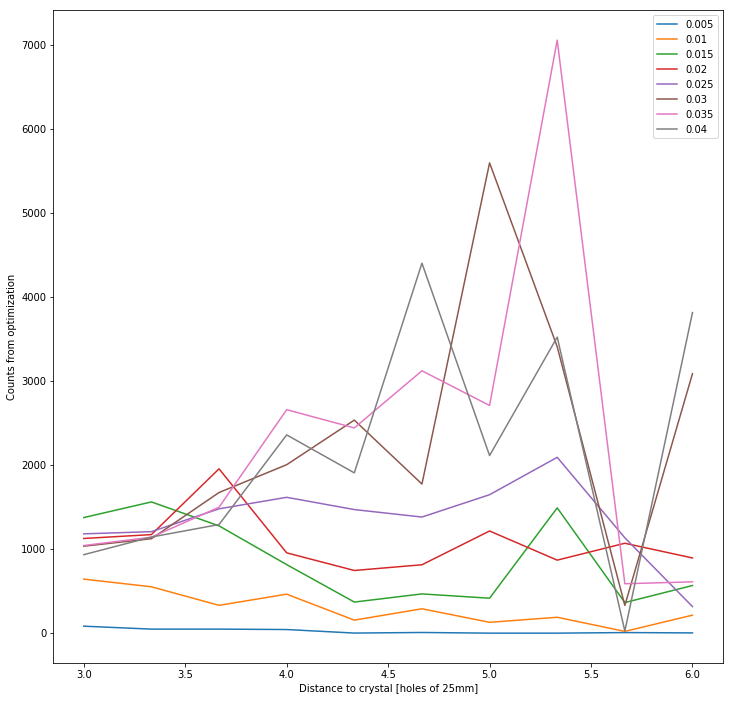

In [11]:
pumps = [[x*0.001,x*0.001] for x in range(5,45,5)] 

xpos=np.linspace(3,6,10)


plt.figure(figsize=[12,12])
for y,pump in enumerate(pumps):
#     c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = pump[0]
    plt.plot(xpos,[max([(lensd_photons_1[y][i][0]) for kk in range(1)]) for i,x in enumerate(xpos)],label=label)

plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()


17
18


17

In [84]:
pumps = [[x*0.001,x*0.001] for x in range(5,50,5)] + [[x*0.001,x*0.001] for x in range(75,300,25)]

plt.figure()
fwhm=np.zeros((len(pumps),len(xpos)))
for y in range(len(pumps)):
    for x,x_pos in enumerate(xpos):
        ydata=lensd_photons_1[y][x][3][0][0:150]/max(lensd_photons_1[y][x][3][0])
        xdata=lensd_photons_1[y][x][3][1][0:150]
        p0 = [1.,780,10]
        coeff, var_matrix = scipy.optimize.curve_fit(gauss, xdata, ydata, p0=p0)                                             
        fwhm[y][x]=coeff[2]
plt.plot(np.tile(xpos*25,(fwhm.shape[0],1)).T,abs(fwhm).T)
plt.show()

NameError: name 'gauss' is not defined

In [40]:
fwhm

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [8]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [48]:
p0 = [1., 780, 10]

coeff, var_matrix = scipy.optimize.curve_fit(gauss, xdata, ydata, p0=p0)

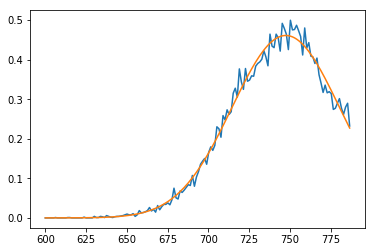

In [49]:
plt.plot(xdata,ydata)
plt.plot(xdata,gauss(xdata,*coeff))
plt.show()

In [92]:
rawdata=[0]

# pump_M2_list=np.array([[1.0577,1.1076],[1.22,1.08],[1.,1],[1.1,1.0]])*1
# pumps = np.array([[0.098334,0.096517],[0.0521,0.096],[0.0325,0.0956],[0.099,0.1485]])
# pump_focus_list=np.array([[2.5+11.9,2.5],[2.5,2.5+23],[2.5,2.5-10.5],[2.5,2.5-34.5]])

for y,p in enumerate(pumps):

    rawdata.append(lensd_photons_1[y][0][0])
    
rawdata[0]=xpos
np.savez("C:/Users/ArianStolk/Documents/26042019_MMF_5mmBBO",rawdata,pumps)

In [2]:
imported=np.load("C:/Users/ArianStolk/Documents/22122017_vertical_ellipse.npz")

imported['arr_2']

NameError: name 'np' is not defined

In [93]:
xpos=[3,4,5,6,7,8,9,10,11,12,13,14,15]
pumps = [[0.098334,0.096517],[0.052,0.096],[0.032,0.096]]
kk=1

plt.figure(figsize=[12,12])
for y in [0,1,2]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_2[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with AC-080-010, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

NameError: name 'lensd_photons_2' is not defined

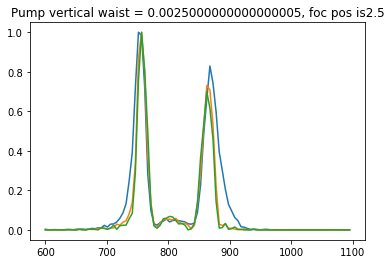

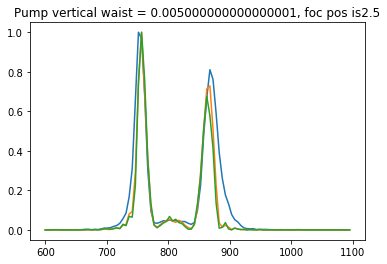

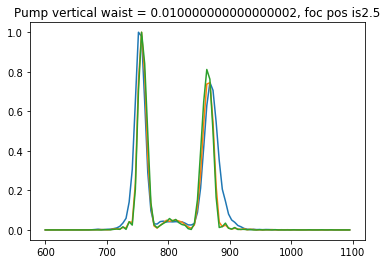

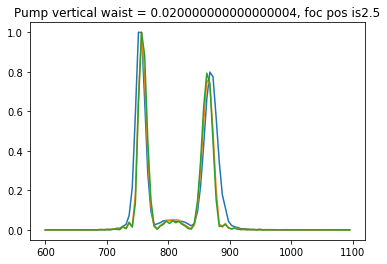

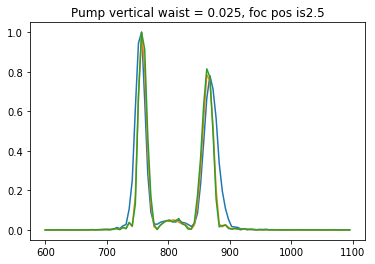

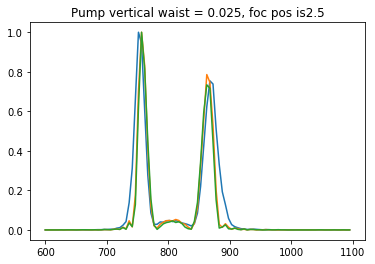

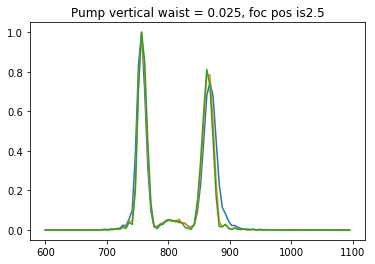

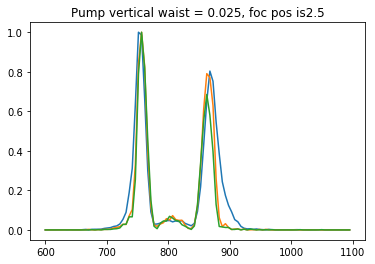

In [51]:
kk=12
for y in range(8):
    plt.figure()
    [plt.plot(lensd_photons_ast[y][x][3+kk][1][0:-1],lensd_photons_ast[y][x][3+kk][0]/max(lensd_photons_ast[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

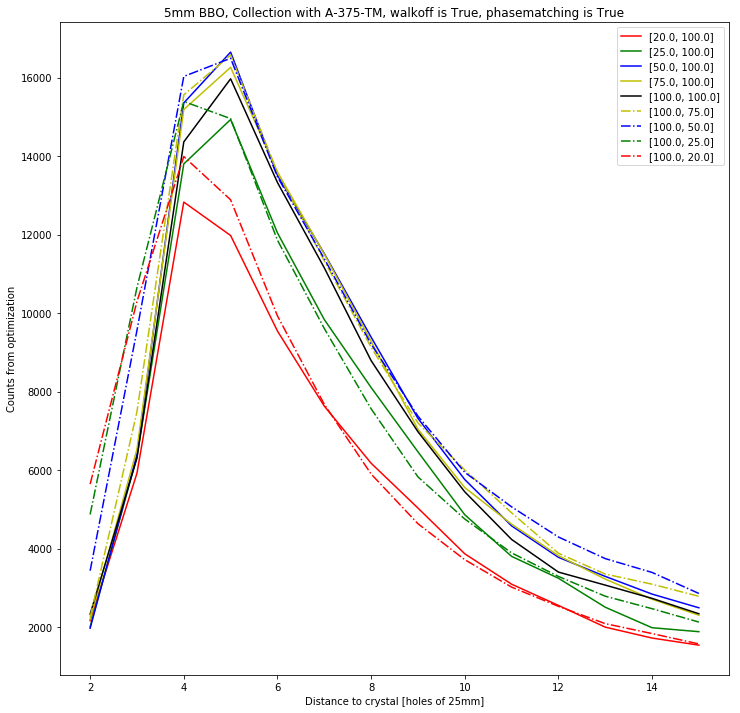

In [16]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[12,12])
for y in [0,1,2,3,4,5,6,7,8]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_asph[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TM, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

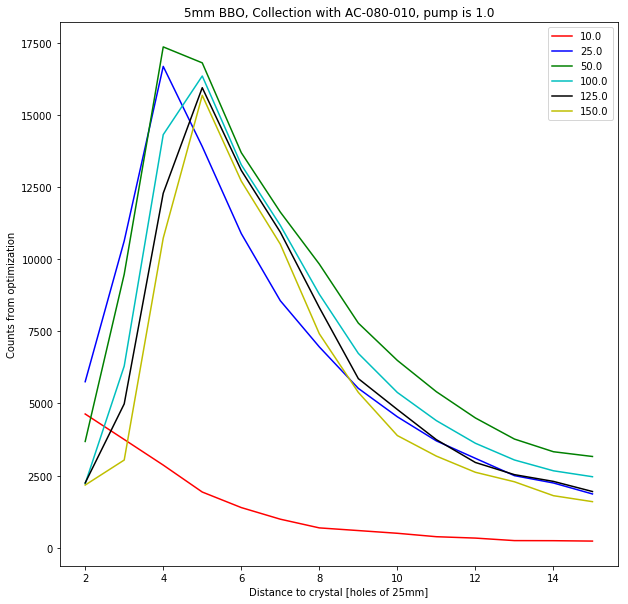

In [8]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[10,10])
for y in [0,1,2,3,4,5]:
    c = ['r-','b-','g-','c-','k-','y-','m-'][y]
    label = 1000*round(pumps_circ[y][1],3)
    plt.plot(xpos,[(lensd_photons_circ_asph[y][i][kk]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TMB, pump is {}".format(pumps_circ[y][1]/pumps_circ[y][0]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

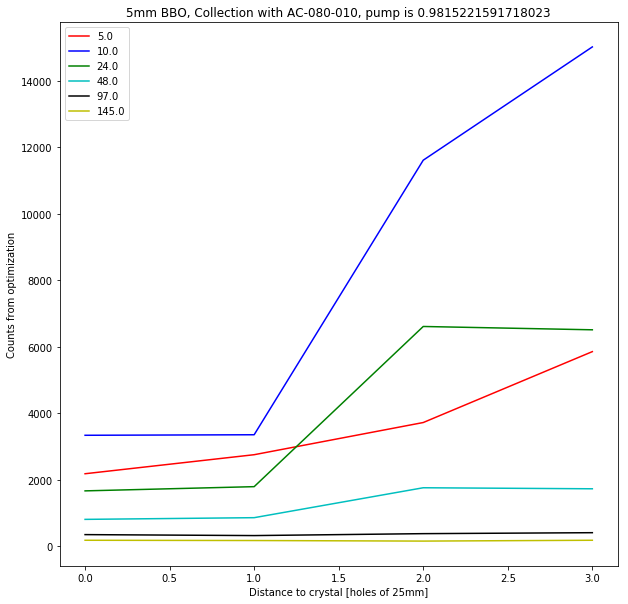

In [42]:
xpos=0
plt.figure(figsize=[10,10]) 
for y in [0,1,2,3,4,5]: 
    c = ['r-','b-','g-','c-','k-','y-','m-'][y] 
    label = 1000*round(pumps[y][1],3)
    plt.plot(range(4),[(lensd_photons[y][xpos][kk*4]) for kk in range(4)],c,label=label) 
    plt.title("5mm BBO, Collection with AC-080-010, pump is {}".format(pumps[y][1]/pumps[y][0])) 
    plt.xlabel("Distance to crystal [holes of 25mm]") 
    plt.ylabel("Counts from optimization") 
plt.legend() 
plt.show()

In [55]:
np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_result_circsym_sweep",lensd_photons)
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_coos_circsym_sweep",np.reshape(lensd_fibre,(6,len([4,5,6,7,8,9,10,11,12,13,14,15]),3)))
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_pumps_circsym_sweep",np.reshape(pumps,(6,2)))

ValueError: setting an array element with a sequence.

In [60]:
lensd_photons[0][0]

[2175,
 0.5867278122471001,
 0.7430816535702084,
 (array([  3,   3,   0,   0,   2,   2,   1,   0,   3,   4,   4,   4,   5,
          15,   6,  13,  20,  17,  20,  28,  32,  45,  55,  53,  88,  79,
         106, 119, 155, 167, 191, 212, 197, 175, 167, 150, 146, 139, 144,
         129, 136, 142, 132, 120, 128, 150, 123, 140, 148, 154, 160, 162,
         181, 188, 199, 175, 154, 151, 119, 124, 107,  87,  64,  80,  47,
          58,  47,  50,  42,  47,  37,  30,  26,  17,  20,  20,  21,  21,
           9,  19,  11,   6,   8,  11,   7,  10,   2,   4,  10,   3,   2,
           5,   3,   1,   0,   2,   1,   2,   0], dtype=int64),
  array([  600.        ,   605.05050505,   610.1010101 ,   615.15151515,
           620.2020202 ,   625.25252525,   630.3030303 ,   635.35353535,
           640.4040404 ,   645.45454545,   650.50505051,   655.55555556,
           660.60606061,   665.65656566,   670.70707071,   675.75757576,
           680.80808081,   685.85858586,   690.90909091,   695.95959596,
    

get_counts_evol([-0.6,0,151],0.1,0.22)

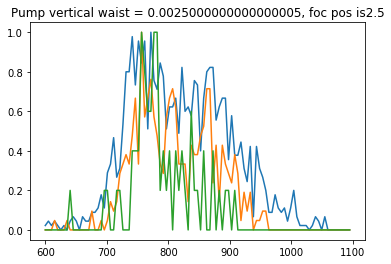

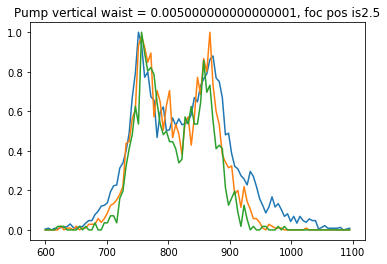

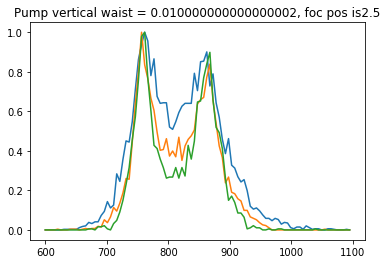

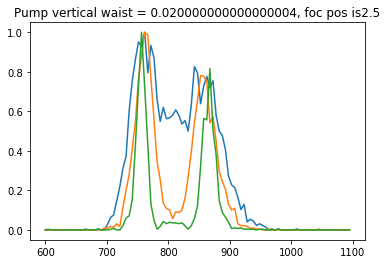

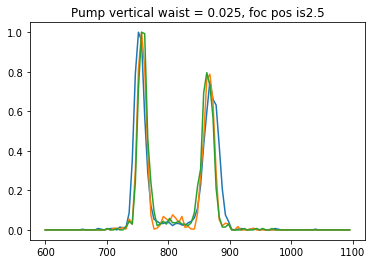

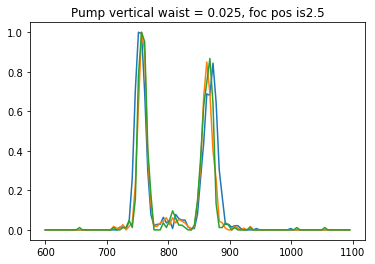

In [42]:
kk=0
for y in range(6):
    plt.figure()
    [plt.plot(lensd_photons[y][x][3+kk][1][0:-1],lensd_photons[y][x][3+kk][0]/max(lensd_photons[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

In [43]:
sum([lensd_photons[1][1][3+z][0] for z in [0,4,8]])

array([   0,    0,    0,    0,    1,    1,    0,    0,    0,    0,    1,
          0,    2,    1,    3,    7,    5,    4,    7,   15,   27,   23,
         95,  235,  489,  764,  944, 1121, 1275, 1624, 2091, 1969, 1291,
        701,  274,  105,   87,   88,  114,   90,  114,  109,   94,   91,
        106,   81,   72,   79,  109,  229,  528,  864, 1292, 1559, 1483,
       1230, 1007,  824,  783,  621,  587,  508,  443,  427,  316,  185,
         86,   59,   40,   25,   20,   10,   10,    3,    8,    4,    3,
          1,    2,    1,    4,    3,    2,    0,    4,    1,    0,    0,
          1,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0], dtype=int64)

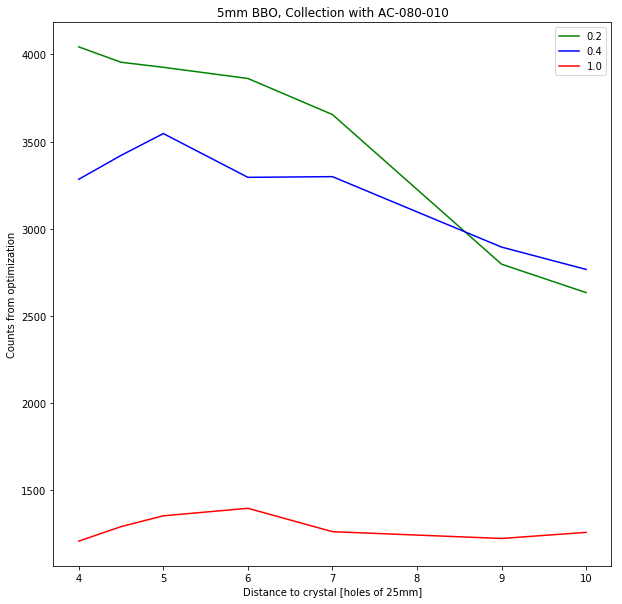

In [43]:
pumps = np.array([[121,28],[119,43],[120,79],[117,117],[78,116],[43,119],[28,121]])/1000
xpos=[4,4.5,5,6,7,9,10]

plt.figure(figsize=[10,10])
for y in [0,1,3]:
    c = ['g-','b-','b-','r-','k-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    plt.plot(xpos,[result_achromat[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.title("5mm BBO, Collection with AC-080-010")
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

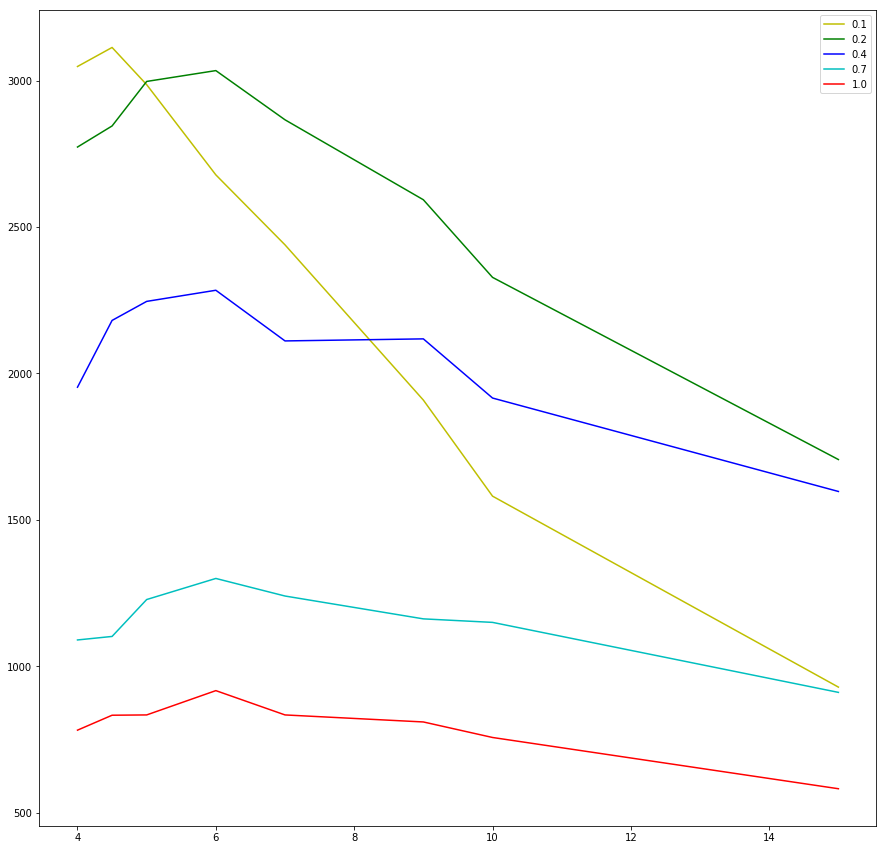

In [30]:
imported_data=np.load("C:/Users/ArianStolk/Documents/ast_sweep_28112017.npz")['arr_0']

plt.figure(figsize=[15,15])
for y in range(5):
    c = ['y-','g-','b-','c-','r-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    xpos=[4,4.5,5,6,7,9,10,15]
    plt.plot(xpos,[imported_data[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.legend()
plt.show()

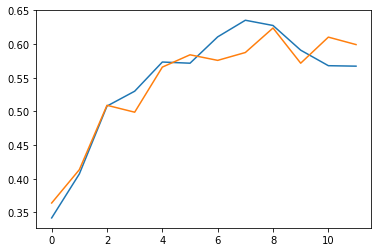

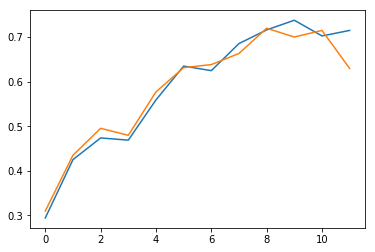

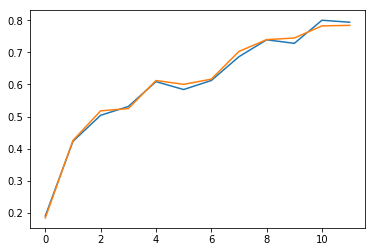

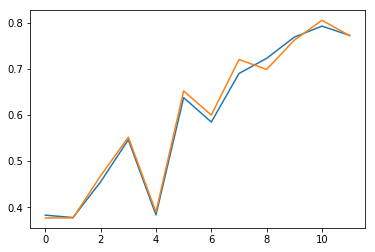

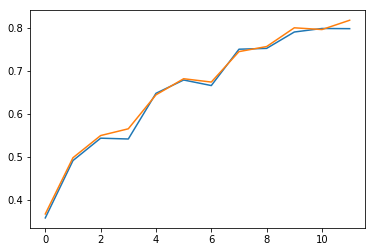

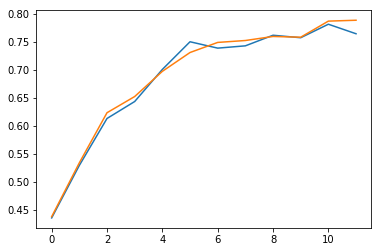

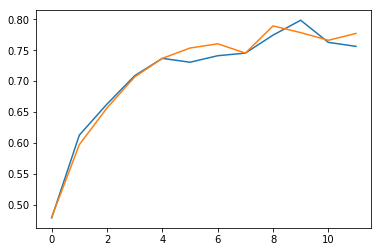

IndexError: list index out of range

In [38]:

for y in range(8):
    plt.figure()
    plt.plot([lensd_photons[y][x][1:3] for x in range(len([2,2.5,3,3.5,4,4.5,5,6,7,9,10,15]))])
    plt.show()


In [118]:
N=10000
M=50

send=np.float32(vis2.complete_results[0][0][...,-1][0:N][...,0:2])
sbeg=np.float32(vis2.complete_results[0][0][...,-2][0:N][...,0:2])

iend=np.float32(vis2.complete_results[1][0][...,-1][0:N][...,0:2])
ibeg=np.float32(vis2.complete_results[1][0][...,-2][0:N][...,0:2])

x,y,z=np.full(M,-0.2,dtype=np.float32),np.full(M,0,dtype=np.float32),np.full(M,61.375+25.,dtype=np.float32)

res=np.empty((M,M,M),dtype=np.float32)

In [119]:

cProfile.run('res=d_coinc(sbeg,send,ibeg,iend,x,y,z)',sort="time")

         3 function calls in 3.869 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.869    3.869    3.869    3.869 <string>:1(<module>)
        1    0.000    0.000    3.869    3.869 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




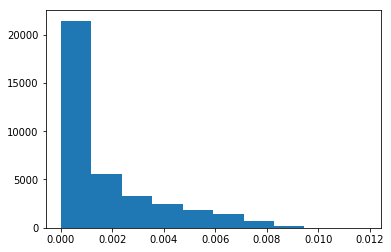

(array([    0,     1,     2, ..., 36958, 36959, 36960], dtype=int64),)

In [59]:
((vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))*(vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))).sum(axis=1)<4*4

array([False, False, False, ..., False,  True,  True], dtype=bool)

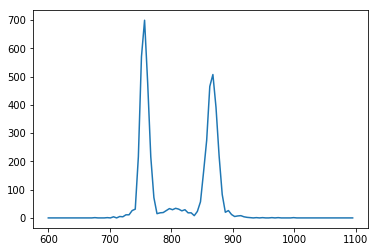

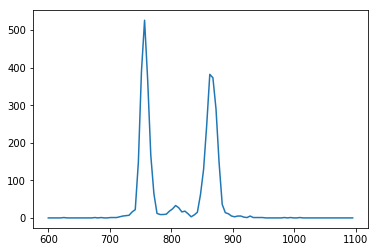

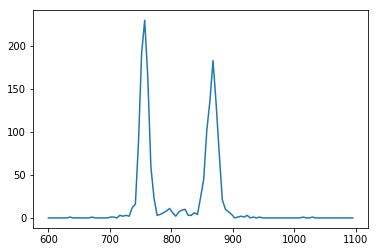

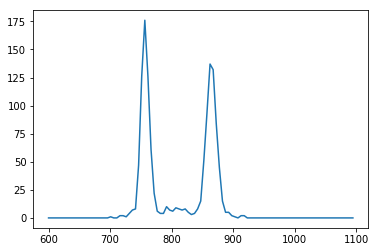

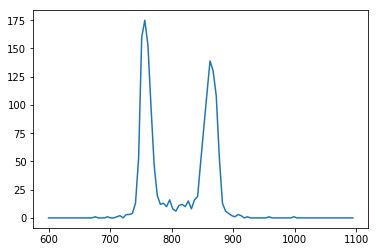

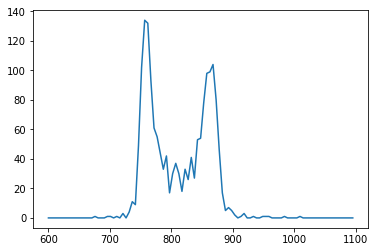

In [48]:
y=0
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=1
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=2
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=3
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=4
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=5
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()

In [34]:
[sum([lensd_photons[0][0][x] for x in [0,4,8,12,16]])

13326

In [37]:
[sum([lensd_photons[y][i][z] for z in [0,4,8,12,16]]) for i,x in enumerate(xpos)]

[13326, 14280, 14146, 14548, 14016, 13037, 12333, 11295, 10658, 7439]

In [16]:
vars(cuda.gpus[0])

{'_device': <weakproxy at 0x0000025C5E5C8958 to Device at 0x0000025C5E4E2198>}

In [31]:
cuda.list_devices().current

In [31]:
0.1/(sqrt(2*log(2)))

0.08493218002880192

1


TypeError: list indices must be integers or slices, not tuple

In [46]:
randomnrs= pcl.rand.normal(0.,1/sqrt(2),1000000,dtype=np.float32, device=False)
np.std(randomnrs)

0.70658433

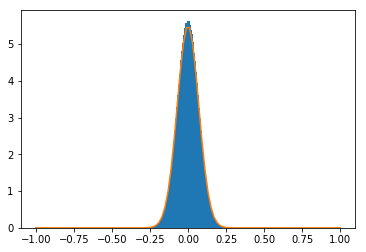

In [47]:
plt.figure()
plt.hist(randomnrs*0.1,100,density=True)
plt.plot(np.linspace(-1,1,100),[exp(-(x**2)/(0.1**2))*5.5 for x in np.linspace(-1,1,100)])
plt.show()

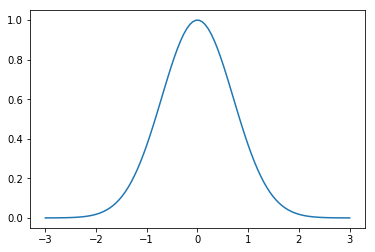

In [34]:
plt.figure()
plt.plot(np.linspace(-3,3,100),[exp(-(x**2)/(1**2)) for x in np.linspace(-3,3,100)])
plt.show()

In [77]:
[[2.5-22.8,2.5]]*5

[[-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5]]

In [43]:
import sys


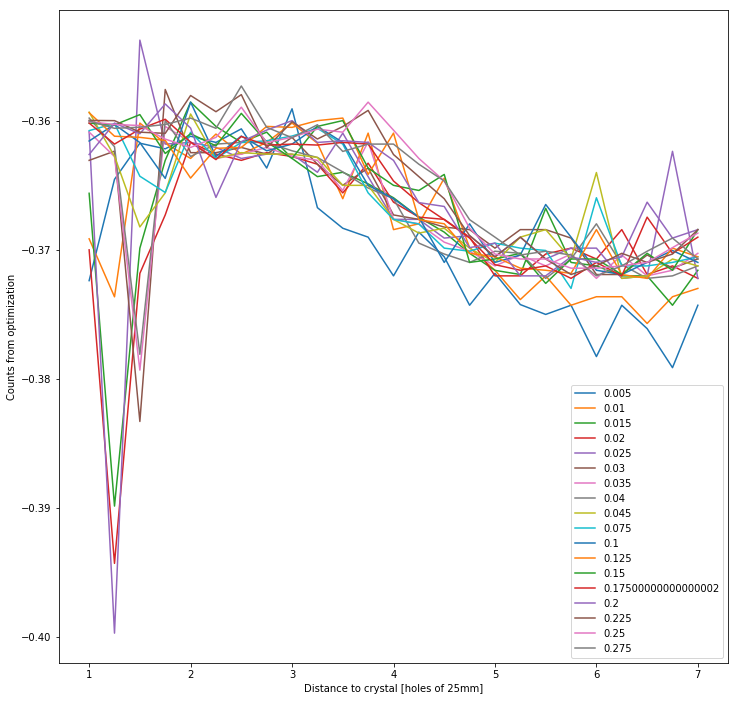

In [23]:
plt.figure(figsize=[12,12])
for y,pump in enumerate(pumps):
#     c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = pump[0]
    plt.plot(xpos,[(lensd_fibre_1[y][i][0]-0.18) for i,x in enumerate(xpos)],label=label)

plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()


[[[-0.19238658, -0.012216143, 35.823341],
  [-0.18453965, 0.0055310186, 42.353439],
  [-0.18173993, 0.0011624397, 48.731655],
  [-0.18217488, 0.0029015094, 54.458508],
  [-0.18119785, -0.00055183168, 60.384483],
  [-0.18167861, -0.00023959417, 66.359177],
  [-0.18062772, -0.0017358456, 72.473259],
  [-0.18366475, -9.3945033e-05, 78.543571],
  [-0.17907324, 0.0018266693, 84.712631],
  [-0.18673335, -0.002410731, 90.834969],
  [-0.18832673, 0.0013473794, 97.003899],
  [-0.18901703, 0.00076436426, 103.20519],
  [-0.19201699, -0.0030915625, 109.37914],
  [-0.18862836, -0.0021641213, 115.58251],
  [-0.19054171, -0.00028280998, 121.79907],
  [-0.19429305, -0.00016331964, 128.01286],
  [-0.19182265, -0.0026485501, 134.21907],
  [-0.19424127, -0.00089950464, 140.44052],
  [-0.19500417, -0.0010771338, 146.64902],
  [-0.19429305, -0.0027982336, 152.88217],
  [-0.19826891, -0.0041771927, 159.09283],
  [-0.19429305, 0.0049308296, 165.35158],
  [-0.1961039, -0.003772289, 171.55565],
  [-0.19912761,

In [27]:
np.meshgrid(np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50))[1].shape

(50, 100)

In [28]:
np.unravel_index(119,[50,100])

(1, 19)